# Use a GAN to generate numbers from MNIST dataset

In [1]:
# usual imports
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Flatten, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D, Convolution2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook

np.random.seed(42)

Using TensorFlow backend.


## Import the MNIST dataset
The dataset contains 60000 images of the numbers 0-9 for training and 10000 for testing. The pictures are in grayscale and 28x28 pixels

In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [3]:
# Preprocessing: 60K 28x28 grayscale pictures with 256 levels of intensity

X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

## Build a generator
The generator takes a noise input vector and applies de-convolution to construct an image. Remember that we are building and stitching together two computational graphs.

In [10]:
# Set the dimensions of the noise
z_dim = 100

In [11]:
# Generator
adam = Adam(lr=0.0002, beta_1=0.5)

g = Sequential()
g.add(Dense(7*7*112, input_dim=z_dim))
g.add(Reshape((7, 7, 112)))
g.add(BatchNormalization())
g.add(Activation(LeakyReLU(alpha=0.2)))
g.add(Conv2DTranspose(56, 5, strides=2, padding='same'))
g.add(BatchNormalization())
g.add(Activation(LeakyReLU(alpha=0.2)))
g.add(Conv2DTranspose(1, 5, strides=2, padding='same', activation='sigmoid'))
g.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 5488)              554288    
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 112)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 112)         448       
_________________________________________________________________
activation_5 (Activation)    (None, 7, 7, 112)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 56)        156856    
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 56)        224       
_________________________________________________________________
activation_6 (Activation)    (None, 14, 14, 56)        0         
__________

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


## Build a discriminator
The discriminator takes an image as input and returns whether it is real or fake.

In [12]:
# Discriminator
d = Sequential()
d.add(Conv2D(56, 5, strides=2, padding='same', input_shape=(28, 28, 1), activation=LeakyReLU(alpha=0.2)))
d.add(Conv2D(112, 5, strides=2, padding='same'))
g.add(BatchNormalization())
g.add(Activation(LeakyReLU(alpha=0.2)))
d.add(Conv2D(224, 5, strides=2, padding='same'))
g.add(Activation(LeakyReLU(alpha=0.2)))
d.add(Flatten())
d.add(Dense(112, activation=LeakyReLU(alpha=0.2)))
d.add(Dense(1, activation='sigmoid'))
d.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
d.summary()

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 56)        1456      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 112)         156912    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 224)         627424    
_________________________________________________________________
flatten_2 (Flatten)          (None, 3584)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 112)               401520    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 113       
Total params: 1,187,425
Trainable params: 1,187,425
Non-trainable params: 0
_________________________________________________________________


## Combine the graphs into a GAN
The input is noise, the hidden layers are the output of the generator, the output is the output of the discriminator.
When we train the generator, the discriminator will not be trainable and viceversa.

In [13]:
d.trainable = False
inputs = Input(shape=(z_dim, ))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 28, 28, 1)         713221    
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 1187425   
Total params: 1,900,646
Trainable params: 712,883
Non-trainable params: 1,187,763
_________________________________________________________________


In [14]:
# Utility functions to plot output and losses
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(generated_images.shape[0], 28, 28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i, :, :], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [15]:
#Set up a vector (dict) to store the losses
losses = {"D":[], "G":[]}
samples = []

## Training procedure
1. Extract a batch of images from the training set
2. Create random noise vectors for the generator
3. Generate images from the noise
4. Set the discriminator to trainable and train it on the generated images
5. Lock the discriminator and train the generator
6. Repeat 1-5 for the desired number of steps in an epoch
7. Repeat for the desired number of epochs

In [16]:
def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    batchCount = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    for e in tqdm_notebook(range(1, epochs+1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):  
            # Create a batch by drawing random index numbers from the training set
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]
            image_batch = image_batch.reshape(image_batch.shape[0], image_batch.shape[1], image_batch.shape[2], 1)
            # Create noise vectors for the generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            
            # Generate the images from the noise
            generated_images = g.predict(noise)
            samples.append(generated_images)
            X = np.concatenate((image_batch, generated_images))
            # Create labels
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9  # One-sided label smoothing

            # Train discriminator on generated images
            d.trainable = True
            d_loss = d.train_on_batch(X, y)

            # Train generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            y2 = np.ones(BATCH_SIZE)
            d.trainable = False
            g_loss = gan.train_on_batch(noise, y2)

        # Only store losses from final batch of epoch
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Update the plots
        if e == 1 or e%plt_frq == 0:
            plot_generated()
    plot_loss(losses)

## Train
Note how the numbers get more realistic as time passes.

Epochs: 200
Batch size: 128
Batches per epoch: 468


A Jupyter Widget

--------------- Epoch 1 ---------------


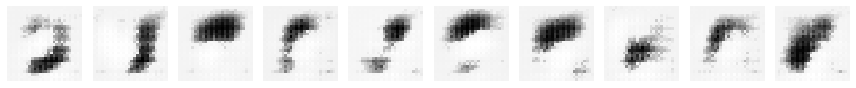

--------------- Epoch 20 ---------------


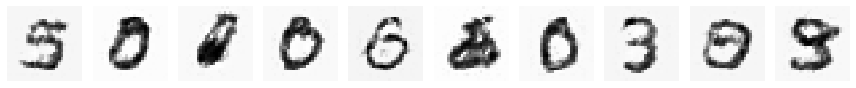

--------------- Epoch 40 ---------------


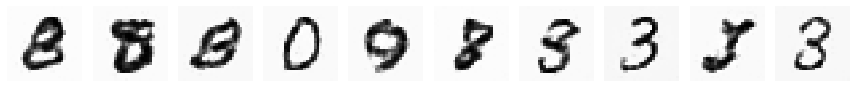

In [ ]:
train(epochs=200, plt_frq=20, BATCH_SIZE=128)